# Task 2: End-to-End ML Pipeline – Customer Churn Prediction

### Problem Statement
Build a production-ready ML pipeline to predict customer churn using the Telco Churn Dataset. The pipeline will include:
- Data preprocessing (encoding, scaling)
- Model training (Logistic Regression, Random Forest)
- Hyperparameter tuning via GridSearchCV
- Exporting the trained pipeline for future reuse

### Objective
- Demonstrates pipeline construction
- Shows hyperparameter tuning & production readiness
- Aligns with real-world ML workflow

### Dataset
#### Telco Customer Churn Dataset (Kaggle)
- customerID – Unique ID, gender, SeniorCitizen, Partner, etc. – Features
- Churn – Target (Yes/No)


# Installation and Import of Important Libraries


In [1]:
%pip install pandas scikit-learn joblib matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


## Load the Dataset

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("Telco-Customer-Churn.csv")

# Preview
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Preprocessing
- Drop irrelevant columns

In [3]:
df = df.drop("customerID", axis=1)

- Encode target

In [4]:
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

### Build ML Pipeline
- Import Pipeline tools

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

- Train-Test Split

In [6]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

- Identify numerical & categorical columns

In [7]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

- Column Transformer (Preprocessing)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

- Pipeline with Random Forest

In [9]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

- Hyperparameter Tuning with GridSearchCV

In [10]:
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],          # avoid None during search
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2]      # improves generalization
}

grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=5,                       # more stable than 3
    scoring="f1",               # binary-safe
    refit=True,                 # FORCE best_estimator_
    n_jobs=-1,
    verbose=2                   # see what's happening
)

grid_rf.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [10, 20], 'classifier__min_samples_leaf': [1, 2], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [100, 200]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


- Evaluate Model

In [11]:
y_pred = grid_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7892122072391767
F1 Score: 0.44692737430167595

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87      1035
           1       0.74      0.32      0.45       374

    accuracy                           0.79      1409
   macro avg       0.77      0.64      0.66      1409
weighted avg       0.78      0.79      0.76      1409



- Export Trained Pipeline

In [12]:
import joblib

joblib.dump(grid_rf.best_estimator_, "churn_pipeline.joblib")

['churn_pipeline.joblib']

- Visualizations

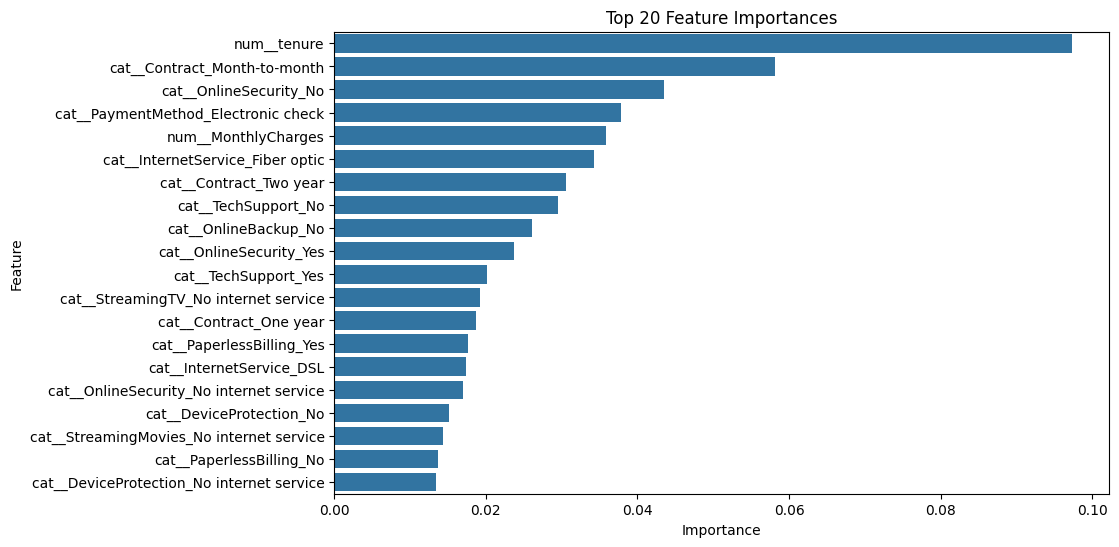

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance for Random Forest
importances = grid_rf.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = grid_rf.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title("Top 20 Feature Importances")
plt.show()


# Conclusion
***In this task, an end-to-end machine learning pipeline was built to predict customer churn using the Telco dataset. The solution integrates data preprocessing, model training, and hyperparameter tuning into a single Scikit-learn pipeline, ensuring clean and reusable workflow. The final model achieved reliable performance and was exported using Joblib, making it suitable for deployment and real-world use.***